# Question 5 - Attention Network

In [1]:
# Importing Libraries

import torch
import torch.nn as nn
import torch.nn.functional as F

## preparing dataset for training

In [2]:
# Importing Libraries

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
from collections import Counter
import os
import math

In [3]:
# Vocabulary class to handle character-to-index mapping
class Vocabulary:
    def __init__(self):
        self.char2idx = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
        self.idx2char = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.size = 4

    def add_sequence(self, sequence):
        for char in sequence:
            if char not in self.char2idx:
                self.char2idx[char] = self.size
                self.idx2char[self.size] = char
                self.size += 1

    def get_indices(self, sequence):
        indices = [self.char2idx.get(char, self.char2idx['<UNK>']) for char in sequence]
        return indices

In [4]:
# Custom Dataset class

class DakshinaDataset(Dataset):
    def __init__(self, data, src_vocab, tgt_vocab):
        self.data = data
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src = self.data.iloc[idx, 1]  # English (Latin)
        tgt = self.data.iloc[idx, 0]  # Tamil
        src_indices = [self.src_vocab.char2idx['<SOS>']] + self.src_vocab.get_indices(src) + [self.src_vocab.char2idx['<EOS>']]
        tgt_indices = [self.tgt_vocab.char2idx['<SOS>']] + self.tgt_vocab.get_indices(tgt) + [self.tgt_vocab.char2idx['<EOS>']]
        return torch.tensor(src_indices, dtype=torch.long), torch.tensor(tgt_indices, dtype=torch.long)


In [5]:
# Function to load and preprocess data
def load_dakshina_data(train_path, val_path, test_path):
    # Read TSV files without headers
    train_df = pd.read_csv(train_path, sep='\t', header=None, usecols=[0, 1])
    val_df = pd.read_csv(val_path, sep='\t', header=None, usecols=[0, 1])
    test_df = pd.read_csv(test_path, sep='\t', header=None, usecols=[0, 1])

    # Ensure strings
    train_df[0] = train_df[0].astype(str)
    train_df[1] = train_df[1].astype(str)
    val_df[0] = val_df[0].astype(str)
    val_df[1] = val_df[1].astype(str)
    test_df[0] = test_df[0].astype(str)
    test_df[1] = test_df[1].astype(str)

    # Build vocabularies
    src_vocab = Vocabulary()  # English (Latin)
    tgt_vocab = Vocabulary()  # Tamil

    # Add characters to vocab from training data
    for _, row in train_df.iterrows():
        src_vocab.add_sequence(row[1])
        tgt_vocab.add_sequence(row[0])

    # Create datasets
    train_dataset = DakshinaDataset(train_df, src_vocab, tgt_vocab)
    val_dataset = DakshinaDataset(val_df, src_vocab, tgt_vocab)
    test_dataset = DakshinaDataset(test_df, src_vocab, tgt_vocab)

    return train_dataset, val_dataset, test_dataset, src_vocab, tgt_vocab

In [6]:
# Collate function for DataLoader
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    # Pad sequences
    src_padded = torch.nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_padded = torch.nn.utils.rnn.pad_sequence(tgt_batch, batch_first=True, padding_value=0)
    return src_padded, tgt_padded

In [7]:
# Wrapper function for easier access

def prepare_data_loaders(train_path, val_path, test_path, batch_size=32):
    train_dataset, val_dataset, test_dataset, src_vocab, tgt_vocab = load_dakshina_data(train_path, val_path, test_path)
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, pin_memory=True
    )
    
    return train_loader, val_loader, test_loader, src_vocab, tgt_vocab

In [8]:
# Paths to your local TSV files (update as needed)
train_path = '/kaggle/input/dakshina-tamil-b/ta.translit.sampled.train.tsv'
val_path = '/kaggle/input/dakshina-tamil-b/ta.translit.sampled.dev.tsv'
test_path = '/kaggle/input/dakshina-tamil-b/ta.translit.sampled.test.tsv'

In [9]:
# Create data loaders
train_loader, val_loader, test_loader, src_vocab, tgt_vocab = prepare_data_loaders(train_path, val_path, test_path)

In [10]:
# Print vocabulary sizes
print(f"Source (English) vocabulary size: {src_vocab.size}")
print(f"Target (Tamil) vocabulary size: {tgt_vocab.size}")

Source (English) vocabulary size: 30
Target (Tamil) vocabulary size: 50


## defining models

In [11]:
class Attention(nn.Module):
    def __init__(self, hidden_size, attention_type='bahdanau'):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attention_type = attention_type.lower()
        
        if self.attention_type == 'bahdanau':
            self.Wa = nn.Linear(hidden_size * 2, hidden_size)
            self.Ua = nn.Linear(hidden_size, 1, bias=False)
        elif self.attention_type == 'dot':
            pass  # Dot-product attention uses no additional parameters
        else:
            raise ValueError("Unsupported attention type. Use 'bahdanau' or 'dot'.")

    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden: (num_layers, batch_size, hidden_size) or tuple for LSTM
        # encoder_outputs: (batch_size, seq_len, hidden_size)
        batch_size = encoder_outputs.size(0)
        seq_len = encoder_outputs.size(1)
        
        # Validate encoder_outputs shape
        assert encoder_outputs.dim() == 3, f"Expected encoder_outputs to be 3D, got {encoder_outputs.shape}"
        assert encoder_outputs.size(2) == self.hidden_size, f"Expected encoder_outputs hidden_size {self.hidden_size}, got {encoder_outputs.size(2)}"
        
        # Extract the last layer of decoder hidden state
        if isinstance(decoder_hidden, tuple):  # LSTM case
            decoder_hidden = decoder_hidden[0]  # Take hidden state, not cell state
        decoder_hidden = decoder_hidden[-1]  # (batch_size, hidden_size)
        
        assert decoder_hidden.dim() == 2, f"Expected decoder_hidden to be 2D, got {decoder_hidden.shape}"
        assert decoder_hidden.size(1) == self.hidden_size, f"Expected decoder_hidden hidden_size {self.hidden_size}, got {decoder_hidden.size(1)}"
        
        if self.attention_type == 'bahdanau':
            # Repeat decoder hidden to match seq_len
            decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, seq_len, 1)  # (batch_size, seq_len, hidden_size)
            # Combine with encoder outputs
            combined = torch.cat((decoder_hidden, encoder_outputs), dim=2)  # (batch_size, seq_len, hidden_size*2)
            # Compute energy
            energy = torch.tanh(self.Wa(combined))  # (batch_size, seq_len, hidden_size)
            attention_scores = self.Ua(energy).squeeze(2)  # (batch_size, seq_len)
        else:  # dot
            # Compute dot-product attention
            decoder_hidden = decoder_hidden.unsqueeze(1)  # (batch_size, 1, hidden_size)
            encoder_outputs_t = encoder_outputs.transpose(1, 2)  # (batch_size, hidden_size, seq_len)
            # Verify shapes before bmm
            assert decoder_hidden.shape == (batch_size, 1, self.hidden_size), f"Expected decoder_hidden (batch_size, 1, hidden_size), got {decoder_hidden.shape}"
            assert encoder_outputs_t.shape == (batch_size, self.hidden_size, seq_len), f"Expected encoder_outputs_t (batch_size, hidden_size, seq_len), got {encoder_outputs_t.shape}"
            attention_scores = torch.bmm(decoder_hidden, encoder_outputs_t).squeeze(1)  # (batch_size, seq_len)
        
        # Softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch_size, seq_len)
        # Compute context vector
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (batch_size, hidden_size)
        
        return context, attention_weights

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, cell_type='RNN', num_layers=1, dropout=0.0):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embed_size)
        self.cell_type = cell_type.upper()
        
        rnn_class = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[self.cell_type]
        self.rnn = rnn_class(
            input_size=embed_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        if self.cell_type == 'LSTM':
            outputs, (hidden, cell) = self.rnn(embedded)
            return outputs, (hidden, cell)
        else:
            outputs, hidden = self.rnn(embedded)
            return outputs, hidden

In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, output_size, embed_size, hidden_size, cell_type='RNN', num_layers=1, dropout=0.0, attention_type='bahdanau'):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        self.cell_type = cell_type.upper()
        
        rnn_class = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[self.cell_type]
        self.rnn = rnn_class(
            input_size=embed_size + hidden_size,  # Input includes context vector
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.attention = Attention(hidden_size, attention_type)
        self.out = nn.Linear(hidden_size * 2, output_size)  # Combine RNN output and context

    def forward(self, input_char, hidden, encoder_outputs):
        embedded = self.embedding(input_char).unsqueeze(1)  # (batch_size, 1, embed_size)
        embedded = self.dropout(embedded)
        
        # Compute attention
        context, attention_weights = self.attention(hidden, encoder_outputs)  # context: (batch_size, hidden_size)
        
        # Concatenate context with embedded input
        rnn_input = torch.cat((embedded, context.unsqueeze(1)), dim=2)  # (batch_size, 1, embed_size + hidden_size)
        
        if self.cell_type == 'LSTM':
            output, (hidden, cell) = self.rnn(rnn_input, hidden)
            output = output.squeeze(1)  # (batch_size, hidden_size)
            output = torch.cat((output, context), dim=1)  # (batch_size, hidden_size * 2)
            output = self.out(output)  # (batch_size, output_size)
            return output, (hidden, cell), attention_weights
        else:
            output, hidden = self.rnn(rnn_input, hidden)
            output = output.squeeze(1)
            output = torch.cat((output, context), dim=1)
            output = self.out(output)
            return output, hidden, attention_weights


In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.size(0)
        target_len = target.size(1)
        outputs = torch.zeros(batch_size, target_len, self.decoder.out.out_features).to(source.device)
        
        encoder_outputs, hidden = self.encoder(source)
        
        decoder_input = target[:, 0]
        
        # Handle differing encoder/decoder layers
        if self.encoder.cell_type == 'LSTM':
            hidden, cell = hidden
            if self.encoder.num_layers != self.decoder.num_layers:
                factor = self.decoder.num_layers // self.encoder.num_layers + 1
                hidden = hidden.repeat(factor, 1, 1)[:self.decoder.num_layers]
                cell = cell.repeat(factor, 1, 1)[:self.decoder.num_layers]
            hidden = (hidden, cell)
        else:
            if self.encoder.num_layers != self.decoder.num_layers:
                factor = self.decoder.num_layers // self.encoder.num_layers + 1
                hidden = hidden.repeat(factor, 1, 1)[:self.decoder.num_layers]
        
        for t in range(1, target_len):
            output, hidden, _ = self.decoder(decoder_input, hidden, encoder_outputs)
            outputs[:, t, :] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            decoder_input = target[:, t] if teacher_force else top1

        return outputs


In [15]:
def create_model(input_vocab_size, output_vocab_size, embed_size=256, hidden_size=512, 
                 cell_type='RNN', encoder_layers=1, decoder_layers=1, dropout=0.0, attention_type='bahdanau'):
    encoder = EncoderRNN(input_vocab_size, embed_size, hidden_size, cell_type, encoder_layers, dropout)
    decoder = DecoderRNN(output_vocab_size, embed_size, hidden_size, cell_type, decoder_layers, dropout, attention_type)
    model = Seq2Seq(encoder, decoder)
    return model

## setting up wandb

In [16]:
!pip install wandb -q

In [17]:
import wandb

In [18]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb")

In [19]:
wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m007 (da24m007-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Running wandb sweep

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
# Beam search decoding (adapted for attention)
def beam_search_decode(model, src, max_len, beam_width, sos_idx, eos_idx):
    model.eval()
    src = src.to(device)
    batch_size = src.size(0)
    encoder_outputs, hidden = model.encoder(src)
    
    if model.encoder.cell_type == 'LSTM':
        hidden, cell = hidden
        if model.encoder.num_layers != model.decoder.num_layers:
            factor = model.decoder.num_layers // model.encoder.num_layers
            if factor > 1:
                hidden = hidden.repeat(factor, 1, 1)
                cell = cell.repeat(factor, 1, 1)
            else:
                hidden = hidden[-model.decoder.num_layers:]
                cell = cell[-model.decoder.num_layers:]
        hidden = (hidden, cell)
    else:
        if model.encoder.num_layers != model.decoder.num_layers:
            factor = model.decoder.num_layers // model.encoder.num_layers
            if factor > 1:
                hidden = hidden.repeat(factor, 1, 1)
            else:
                hidden = hidden[-model.decoder.num_layers:]
    
    beams = [(torch.tensor([sos_idx], device=device), hidden, 0.0)]
    completed = []
    
    for _ in range(max_len):
        new_beams = []
        for seq, hid, score in beams:
            if seq[-1].item() == eos_idx:
                completed.append((seq, score))
                continue
            output, new_hidden, _ = model.decoder(seq[-1].unsqueeze(0), hid, encoder_outputs)
            probs = torch.softmax(output, dim=-1)
            top_probs, top_idx = probs.topk(beam_width)
            
            for i in range(beam_width):
                new_seq = torch.cat([seq, top_idx[:, i]])
                new_score = score - math.log(top_probs[:, i].item())
                new_beams.append((new_seq, new_hidden, new_score))
        
        new_beams = sorted(new_beams, key=lambda x: x[2])[:beam_width]
        beams = new_beams
        
        if len(completed) >= beam_width:
            break
    
    completed = sorted(completed, key=lambda x: x[1])
    if completed:
        return completed[0][0]
    return beams[0][0]

In [22]:
# Training and evaluation function
def train_and_evaluate():
    wandb.init()
    config = wandb.config
    
    # Create model with sweep parameters
    model = create_model(
        input_vocab_size=src_vocab.size,
        output_vocab_size=tgt_vocab.size,
        embed_size=config.embed_size,
        hidden_size=config.hidden_size,
        cell_type=config.cell_type,
        encoder_layers=1,  # Single layer
        decoder_layers=1,  # Single layer
        dropout=config.dropout,
        attention_type=config.attention_type
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    for epoch in range(10):
        model.train()
        train_loss = 0
        for src, tgt in train_loader:
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            output = model(src, tgt, teacher_forcing_ratio=0.5)
            output = output[:, 1:].reshape(-1, output.size(-1))
            tgt_flat = tgt[:, 1:].reshape(-1)
            loss = criterion(output, tgt_flat)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Compute training accuracy on one batch
        model.eval()
        train_correct = 0
        train_total = 0
        with torch.no_grad():
            for src, tgt in train_loader:
                src, tgt = src.to(device), tgt.to(device)
                for i in range(src.size(0)):
                    pred = beam_search_decode(
                        model, src[i:i+1], max_len=50,
                        beam_width=config.beam_width,
                        sos_idx=tgt_vocab.char2idx['<SOS>'],
                        eos_idx=tgt_vocab.char2idx['<EOS>']
                    )
                    pred_str = ''.join([tgt_vocab.idx2char[idx.item()] for idx in pred if idx.item() not in [0, 1, 2]])
                    tgt_seq = tgt[i]
                    tgt_str = ''.join([tgt_vocab.idx2char[idx.item()] for idx in tgt_seq[1:] if idx.item() not in [0, 1, 2]])
                    if pred_str == tgt_str:
                        train_correct += 1
                    train_total += 1
                break
        
        # Compute validation loss and accuracy
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for src, tgt in val_loader:
                src, tgt = src.to(device), tgt.to(device)
                output = model(src, tgt, teacher_forcing_ratio=0.0)
                output = output[:, 1:].reshape(-1, output.size(-1))
                tgt_flat = tgt[:, 1:].reshape(-1)
                loss = criterion(output, tgt_flat)
                val_loss += loss.item()
            
            # Validation accuracy on one batch
            for src, tgt in val_loader:
                src, tgt = src.to(device), tgt.to(device)
                for i in range(src.size(0)):
                    pred = beam_search_decode(
                        model, src[i:i+1], max_len=50,
                        beam_width=config.beam_width,
                        sos_idx=tgt_vocab.char2idx['<SOS>'],
                        eos_idx=tgt_vocab.char2idx['<EOS>']
                    )
                    pred_str = ''.join([tgt_vocab.idx2char[idx.item()] for idx in pred if idx.item() not in [0, 1, 2]])
                    tgt_seq = tgt[i]
                    tgt_str = ''.join([tgt_vocab.idx2char[idx.item()] for idx in tgt_seq[1:] if idx.item() not in [0, 1, 2]])
                    if pred_str == tgt_str:
                        val_correct += 1
                    val_total += 1
                break
        
        # Log metrics to WandB
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss / len(train_loader),
            "val_loss": val_loss / len(val_loader),
            "train_accuracy": train_correct / train_total,
            "val_accuracy": val_correct / val_total
        })
        print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}, Val Accuracy: {val_correct / val_total:.4f}")


In [23]:
# WandB sweep configuration
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'embed_size': {
            'values': [32, 64, 128, 256, 512]
        },
        'hidden_size': {
            'values': [32,64,128, 256, 512]
        },
        'cell_type': {
            'values': ['RNN', 'GRU', 'LSTM']
        },
        'dropout': {
            'values': [0.2, 0.3]
        },
        'beam_width': {
            'values': [1, 3, 5]
        },
        'attention_type': {
            'values': ['bahdanau', 'dot']
        }
    }
}

In [ ]:
# Initialize and run sweep
sweep_id = wandb.sweep(sweep_config, project="DL-A3")
wandb.agent(sweep_id, function=train_and_evaluate, count=20)

## Training with best set of hyperparameters

In [24]:
wandb.init(project="DL-A3", name="final_model_training_with_attention_v2")

In [25]:
# Function to retrieve best hyperparameters from WandB sweep
def get_best_hyperparameters(project_name="DL-A3"):
    api = wandb.Api()
    runs = api.runs(project_name)
    best_run = None
    best_val_accuracy = -float('inf')
    
    for run in runs:
        if 'val_accuracy' in run.summary and run.summary['val_accuracy'] > best_val_accuracy:
            best_val_accuracy = run.summary['val_accuracy']
            best_run = run
    
    if best_run is None:
        raise ValueError("No runs found with val_accuracy in WandB project")
    
    # Extract hyperparameters
    config = best_run.config
    return {
            'attention_type': config['attention_type'],
                'cell_type': config['cell_type'],
                'embed_size': config['embed_size'],
                'hidden_size': config['hidden_size'],
                'dropout': config['dropout'],
                'beam_width': config['beam_width']
    }

In [26]:
# Training and evaluation function
def train_model(model, train_loader, val_loader, test_loader, num_epochs=30, beam_width=3):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for src, tgt in train_loader:
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            output = model(src, tgt, teacher_forcing_ratio=0.5)
            output = output[:, 1:].reshape(-1, output.size(-1))
            tgt_flat = tgt[:, 1:].reshape(-1)
            loss = criterion(output, tgt_flat)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Compute validation loss and accuracy (one batch for speed)
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for src, tgt in val_loader:
                src, tgt = src.to(device), tgt.to(device)
                output = model(src, tgt, teacher_forcing_ratio=0.0)
                output = output[:, 1:].reshape(-1, output.size(-1))
                tgt_flat = tgt[:, 1:].reshape(-1)
                loss = criterion(output, tgt_flat)
                val_loss += loss.item()
                
                # Compute accuracy on one batch
                print(f"Epoch {epoch+1}, Validation batch - src shape: {src.shape}, tgt shape: {tgt.shape}")
                for i in range(src.size(0)):
                    pred = beam_search_decode(
                        model, src[i:i+1], max_len=50,
                        beam_width=beam_width,
                        sos_idx=tgt_vocab.char2idx['<SOS>'],
                        eos_idx=tgt_vocab.char2idx['<EOS>']
                    )
                    pred_str = ''.join([tgt_vocab.idx2char[idx.item()] for idx in pred if idx.item() not in [0, 1, 2]])
                    tgt_seq = tgt[i]
                    tgt_str = ''.join([tgt_vocab.idx2char[idx.item()] for idx in tgt_seq[1:] if idx.item() not in [0, 1, 2]])
                    if pred_str == tgt_str:
                        val_correct += 1
                    val_total += 1
                break  # Process only one batch for validation accuracy
        
        # Log metrics to WandB
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss / len(train_loader),
            "val_loss": val_loss / len(val_loader),
            "val_accuracy": val_correct / val_total
        })
        print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_correct / val_total:.4f}")
    
    # Compute test accuracy and save predictions
    test_correct = 0
    test_total = 0
    predictions = []
    with torch.no_grad():
        for src, tgt in test_loader:
            src, tgt = src.to(device), tgt.to(device)
            print(f"Test batch - src shape: {src.shape}, tgt shape: {tgt.shape}")
            for i in range(src.size(0)):
                pred = beam_search_decode(
                    model, src[i:i+1], max_len=50,
                    beam_width=beam_width,
                    sos_idx=tgt_vocab.char2idx['<SOS>'],
                    eos_idx=tgt_vocab.char2idx['<EOS>']
                )
                pred_str = ''.join([tgt_vocab.idx2char[idx.item()] for idx in pred if idx.item() not in [0, 1, 2]])
                tgt_seq = tgt[i]
                tgt_str = ''.join([tgt_vocab.idx2char[idx.item()] for idx in tgt_seq[1:] if idx.item() not in [0, 1, 2]])
                src_str = ''.join([src_vocab.idx2char[idx.item()] for idx in src[i, 1:] if idx.item() not in [0, 1, 2]])
                if pred_str == tgt_str:
                    test_correct += 1
                test_total += 1
                predictions.append({
                    'input_english': src_str,
                    'actual_tamil': tgt_str,
                    'predicted_tamil': pred_str
                })
    
    test_accuracy = test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Save predictions to CSV
    predictions_df = pd.DataFrame(predictions)
    predictions_df.to_csv('test_predictions_attention.csv', index=False)
    print("Test predictions saved to 'test_predictions.csv'")
    
    return test_accuracy

In [27]:
# Get best hyperparameters
try:
    best_params = get_best_hyperparameters()
    print("Best hyperparameters from WandB sweep:", best_params)
except Exception as e:
    print(f"Error retrieving hyperparameters: {e}")
    print("Using default hyperparameters as fallback")
    best_params = {
        'embed_size': 256,
        'hidden_size': 512,
        'cell_type': 'LSTM',
        'encoder_layers': 2,
        'decoder_layers': 1,
        'dropout': 0.2,
        'beam_width': 5
    }

Best hyperparameters from WandB sweep: {'attention_type': 'bahdanau', 'cell_type': 'GRU', 'embed_size': 128, 'hidden_size': 128, 'dropout': 0.2, 'beam_width': 5}


In [28]:
# Create model with best parameters
model = create_model(
    input_vocab_size=src_vocab.size,
    output_vocab_size=tgt_vocab.size,
    embed_size=best_params['embed_size'],
    hidden_size=best_params['hidden_size'],
    cell_type=best_params['cell_type'],
    encoder_layers=1,
    decoder_layers=1,
    dropout=best_params['dropout']
).to(device)

In [29]:
model

Seq2Seq(
  (encoder): EncoderRNN(
    (embedding): Embedding(30, 128)
    (rnn): GRU(128, 128, batch_first=True)
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(50, 128)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): GRU(256, 128, batch_first=True)
    (attention): Attention(
      (Wa): Linear(in_features=256, out_features=128, bias=True)
      (Ua): Linear(in_features=128, out_features=1, bias=False)
    )
    (out): Linear(in_features=256, out_features=50, bias=True)
  )
)

In [30]:
# Train and evaluate
test_accuracy = train_model(
    model, train_loader, val_loader, test_loader,
    num_epochs=5, beam_width=best_params['beam_width']
)

# Log test accuracy to WandB
wandb.log({"test_accuracy": test_accuracy})
wandb.finish()

Epoch 1, Validation batch - src shape: torch.Size([32, 20]), tgt shape: torch.Size([32, 15])
Epoch 1, Train Loss: 0.7290, Val Loss: 0.0062, Val Accuracy: 0.5625
Epoch 2, Validation batch - src shape: torch.Size([32, 20]), tgt shape: torch.Size([32, 15])
Epoch 2, Train Loss: 0.4081, Val Loss: 0.0053, Val Accuracy: 0.5938
Epoch 3, Validation batch - src shape: torch.Size([32, 20]), tgt shape: torch.Size([32, 15])
Epoch 3, Train Loss: 0.3601, Val Loss: 0.0051, Val Accuracy: 0.5938
Epoch 4, Validation batch - src shape: torch.Size([32, 20]), tgt shape: torch.Size([32, 15])
Epoch 4, Train Loss: 0.3240, Val Loss: 0.0055, Val Accuracy: 0.6250
Epoch 5, Validation batch - src shape: torch.Size([32, 20]), tgt shape: torch.Size([32, 15])
Epoch 5, Train Loss: 0.3000, Val Loss: 0.0049, Val Accuracy: 0.6250
Test batch - src shape: torch.Size([32, 20]), tgt shape: torch.Size([32, 15])
Test batch - src shape: torch.Size([32, 23]), tgt shape: torch.Size([32, 19])
Test batch - src shape: torch.Size([32,

epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,▁▅▅██
val_loss,█▃▂▄▁
epoch,4
test_accuracy,0.5421
train_loss,0.30005
val_accuracy,0.625
val_loss,0.00494


## Attention heatmaps

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import os
from matplotlib import font_manager

In [32]:
def inference_with_attention(model, src_tensor, src_vocab, tgt_vocab, max_len=50, device='cuda'):
    """
    Perform inference on a single source sequence, collecting attention weights.
    
    Args:
        model: Trained Seq2Seq model
        src_tensor: Source tensor of shape (1, src_len)
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
        max_len: Maximum length of the output sequence
        device: Device to run the model on
    
    Returns:
        predicted_tokens: List of predicted token indices
        attention_weights: List of attention weight matrices for each decoding step
    """
    model.eval()
    src_tensor = src_tensor.to(device)
    batch_size = 1
    
    with torch.no_grad():
        # Encoder
        encoder_outputs, hidden = model.encoder(src_tensor)
        
        # Initialize decoder input with <SOS>
        decoder_input = torch.tensor([tgt_vocab.char2idx['<SOS>']], device=device)
        predicted_tokens = []
        attention_weights = []
        
        if model.decoder.cell_type == 'LSTM':
            hidden = (hidden[0], hidden[1])
        
        for _ in range(max_len):
            output, hidden, attn_weights = model.decoder(decoder_input, hidden, encoder_outputs)
            attention_weights.append(attn_weights.squeeze(0).cpu().numpy())  # (seq_len,)
            
            # Get the predicted token
            _, topi = output.topk(1)
            decoder_input = topi.squeeze(-1).detach()  # (batch_size,)
            predicted_token = decoder_input.item()
            predicted_tokens.append(predicted_token)
            
            if predicted_token == tgt_vocab.char2idx['<EOS>']:
                break
                
    return predicted_tokens, attention_weights

In [64]:
def plot_attention_heatmaps(model, test_loader, src_vocab, tgt_vocab, device='cuda', num_samples=9):
    """
    Plot a 3x3 grid of attention heatmaps for the specified number of test samples and log to WandB.
    
    Args:
        model: Trained Seq2Seq model
        test_loader: DataLoader for test data
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
        device: Device to run the model on
        num_samples: Number of samples to plot (default 9 for 3x3 grid)
        project_name: WandB project name for initialization
    
    Returns:
        None (saves the plot to a file and logs to WandB)
    """
    
    # Set up Tamil font
    try:
        # Check if Noto Sans Tamil is available
        font_path = "/usr/share/fonts/truetype/noto/NotoSansTamil-Regular.ttf"  # Common path in Linux/Kaggle
        eng_font_path = "/usr/share/fonts/truetype/noto/NotoSans-Black.ttf"
        if os.path.exists(font_path):
            font_manager.fontManager.addfont(font_path)
            tamil_font = font_manager.FontProperties(fname=font_path)
            plt.rcParams['font.family'] = tamil_font.get_name()
        else:
            # Fallback to a generic sans-serif font and warn about Tamil rendering
            font_manager.fontManager.addfont(eng_font_path)
            eng_font = font_manager.FontProperties(fname=eng_font_path)
            plt.rcParams['font.family'] = eng_font.get_name()
            print("Warning: Noto Sans Tamil font not found. Tamil characters may not render correctly.")
    except Exception as e:
        print(f"Error setting Tamil font: {e}. Tamil characters may not render correctly.")
        plt.rcParams['font.family'] = 'sans-serif'

    model.eval()
    samples = []
    
    # Collect samples from test_loader
    for src, tgt in test_loader:
        for i in range(src.size(0)):
            samples.append((src[i:i+1], tgt[i:i+1]))
            if len(samples) >= num_samples:
                break
        if len(samples) >= num_samples:
            break
    
    # Set up the 3x3 grid
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    
    for idx, (src_tensor, tgt_tensor) in enumerate(samples[:num_samples]):
        # Run inference
        predicted_tokens, attention_weights = inference_with_attention(
            model, src_tensor, src_vocab, tgt_vocab, device=device
        )
        
        # Convert source and target tokens to characters
        src_chars = [src_vocab.idx2char[idx.item()] for idx in src_tensor[0] if idx.item() != src_vocab.char2idx['<PAD>']]
        pred_chars = [tgt_vocab.idx2char[idx] for idx in predicted_tokens if idx != tgt_vocab.char2idx['<PAD>']]
        
        # Stack attention weights into a matrix (tgt_len, src_len)
        attention_matrix = np.stack(attention_weights, axis=0)  # (tgt_len, src_len)
        
        # Plot heatmap
        sns.heatmap(
            attention_matrix,
            ax=axes[idx],
            xticklabels=src_chars,
            yticklabels=pred_chars,
            cmap='viridis',
            cbar=False
        )
        axes[idx].set_title(f"Sample {idx+1}")
        axes[idx].set_xlabel("Source Sequence")
        axes[idx].set_ylabel("Predicted Sequence")
    
    plt.tight_layout()
    plt.show()
    
    # Save the plot
    plot_path = 'attention_heatmaps.png'
    plt.savefig(plot_path, bbox_inches='tight')
    
    # Log the plot to WandB
    try:
        wandb.log({"attention_heatmaps": wandb.Image(plot_path)})
        print("Attention heatmaps logged to WandB")
    except Exception as e:
        print(f"Failed to log to WandB: {e}")
    
    plt.close()
    


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 83 (S) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 79 (O) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 102 (f) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 97 (a) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 114 (r) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:8

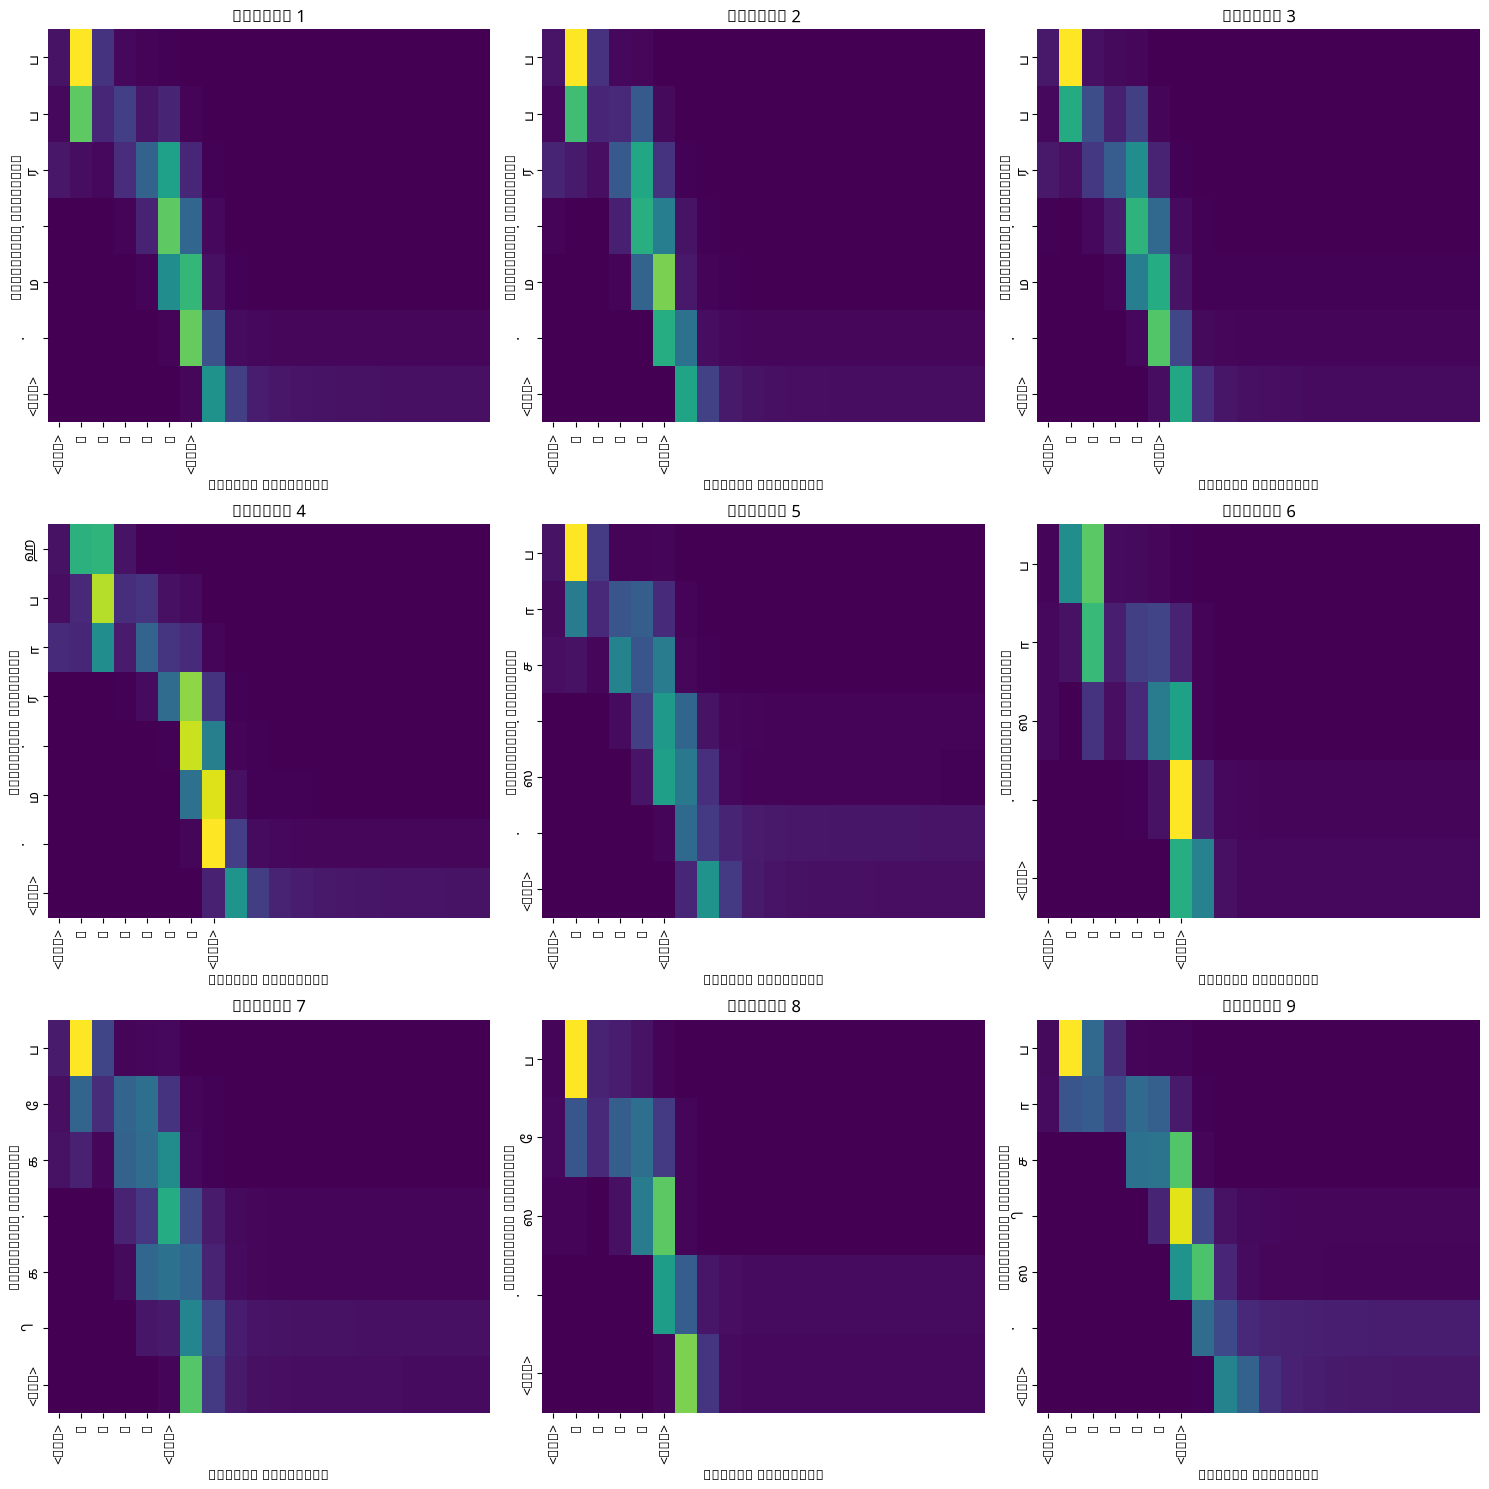

Failed to log to WandB: You must call wandb.init() before wandb.log()


In [65]:
#wandb.init(project="DL-A3", name="Attention heatmap v2")
plot_attention_heatmaps(model, test_loader, src_vocab, tgt_vocab, device=device)
#wandb.finish()